# Set Up

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import random
import math
%matplotlib inline

from os import path, getcwd
from glob import glob

code_dir = getcwd()
data_dir = path.expanduser('~/data/workshop-content18/3-snc/data/')

ais_pathnames = glob(data_dir + '*.txt')
ais_basenames = [path.basename(pn) for pn in ais_pathnames]

delta_cur_basename = next(bn for bn in ais_basenames if 'Deltaport_Current' in bn)
delta_his_basename = next(bn for bn in ais_basenames if 'Deltaport_History' in bn)
nwest_cur_basename = next(bn for bn in ais_basenames if 'NewWestminster_Current' in bn)
nwest_his_basename = next(bn for bn in ais_basenames if 'NewWestminster_History' in bn)

max_rows=int(3e6)
delta_cur = pd.read_csv(
    data_dir + delta_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

delta_his = pd.read_csv(
    data_dir + delta_his_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

nwest_cur = pd.read_csv(
    data_dir + nwest_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

nwest_his = pd.read_csv(
    data_dir + nwest_his_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

delta_cur = pd.concat([delta_cur, delta_his, nwest_cur, nwest_his])

# Clean up memory
delta_his = None
nwest_cur = None
nwest_his = None

In [3]:
# Only keep interesting data and drom the data missing stuff
#delta_cur = delta_cur.loc[:, ['UserID', 'Longitude', 'Latitude', 'ROT']]
print(delta_cur.size)
delta_cur = delta_cur.dropna()
print(delta_cur.size)

127290540
127290504


In [4]:
NUM = 1000

START_X = -124
END_X = -122

START_Y = 48.2
END_Y = 49.7

#START_X = -122.64
#END_X = -122 #-122.63 # -122

#START_Y = 48.2 # 49.340 # 48.2
#END_Y = 49.345

dx = (END_X - START_X)/NUM
dy = (END_Y - START_Y)/NUM

# Clean up memory
H = None

# Select ships within a certain bin, and compute mean heading (ignore)
good_angles = delta_cur.loc[delta_cur['TrueHeading'] < 360]

# Clean up memory
delta_cur = None

# Motion map
Now let's build a scalar field of ship directions of motion

In [5]:
good_angles['i']=good_angles['Longitude'].apply(lambda x: int(math.floor((x-START_X)/dx)))
good_angles['j']=good_angles['Latitude'].apply(lambda y: int(math.floor((y-START_Y)/dy)))
z = good_angles.groupby(by=['i','j'])

In [6]:
%%time
dmap = np.zeros([NUM,NUM])
smap = np.zeros([NUM,NUM])

for idx, item in z:
    i = idx[0]
    j = idx[1]
    if (i >= 0 and j >= 0) and (i < NUM and j < NUM):
        dmap[j,i] = np.mean(item.TrueHeading.values)
        smap[j,i] = np.std(item.TrueHeading.values)

CPU times: user 21.1 s, sys: 230 ms, total: 21.3 s
Wall time: 21.3 s


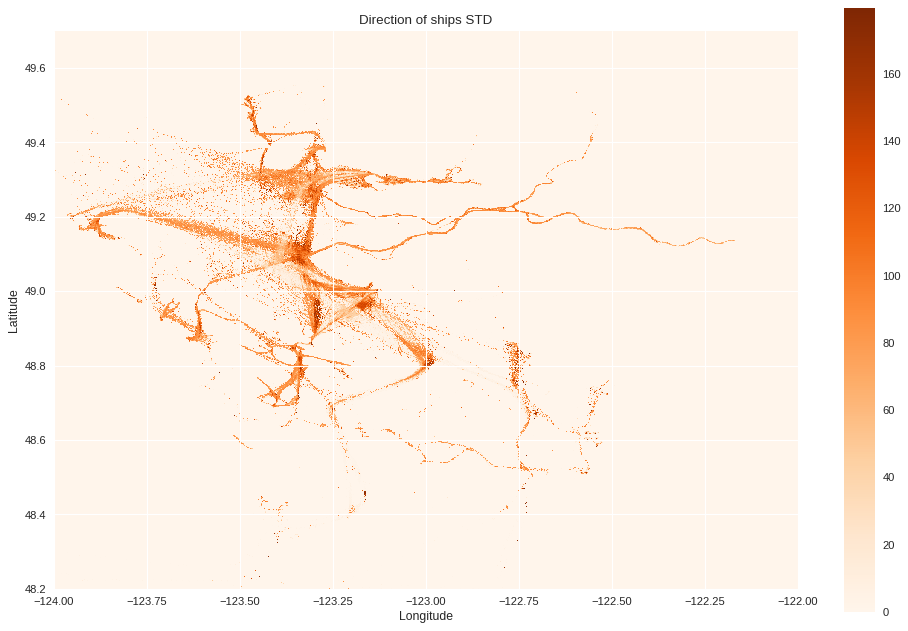

In [7]:
fig = plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Direction of ships STD")

xedges = np.linspace(START_X, END_X, num=NUM)
yedges = np.linspace(START_Y, END_Y,num=NUM)

cax = plt.imshow(smap, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.Oranges)

cbar = fig.colorbar(cax)

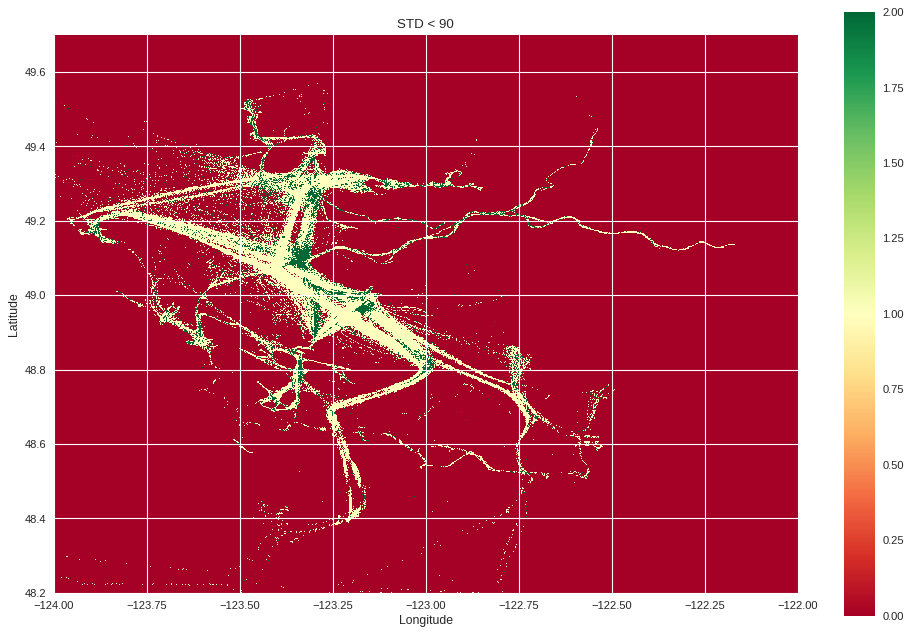

In [8]:
H = np.copy(smap)
H[(smap > 0) & (smap < 90)] = 1
H[smap >= 90] = 2
fig = plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="STD < 90")
cax = plt.imshow(H, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.RdYlGn)

cbar = fig.colorbar(cax)

H = None

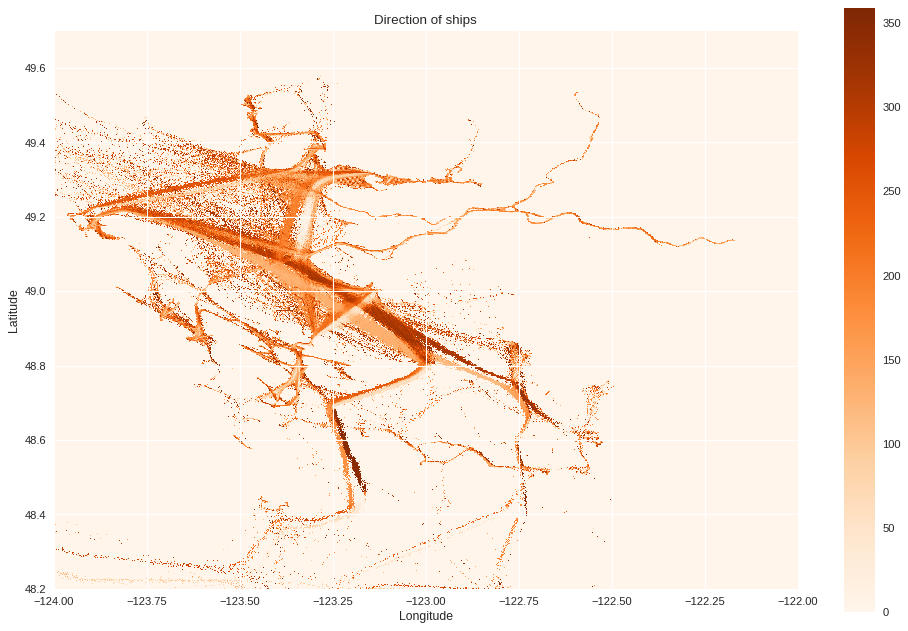

In [9]:
fig = plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Direction of ships")


cax = plt.imshow(dmap, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.Oranges)

cbar = fig.colorbar(cax)

In [10]:
dx

0.002

In [11]:
dy

0.0015

# Streamplot